In [1]:
import numpy as np

#https://www.jianshu.com/p/af5435802f4b,有比较清晰地说明
#节点，抽象类，基类
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented #当比较操作和二元运算中遇到不支持的类型时，会返回这个对象
    

    def backward(self):

        raise NotImplemented

#输入节点
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self) #把node的属性、变量也一并初始化了

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            # 输入节点的梯度等于所有输出的梯度相加
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1 #这里是不需要求偏导的，*1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N

# Add子类（对Input实例进行加法运算）
# Add是对多个输入节点进行相加，因此Add类必须有传入节点，且传入节点需要封装成列表传入基类Node的构造函数中。
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))  #这里把前面神经元的输出值都累加起来，但没有非线性映射
        ## when execute forward, this node caculate value as defined.

#线性相加节点
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value #nodes ，x
        weights = self.inputs[1].value # w
        bias = self.inputs[2].value # b

        self.value = np.dot(inputs, weights) + bias

    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs} #生成一个与inputs规格相同的全零数组

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #grad_cost用来存储之前节点求导的梯度,根据链式法则，对中间节点求梯度需要用到之前节点的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T) 
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False) #因为是1，直接sum

        # WX + B / W ==> X
        # WX + B / X ==> W
        # WX + B / B ==> 1

#Sigmoid激活函数节点
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.


#计算均方误差节点
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1) #y
        a = self.inputs[1].value.reshape(-1, 1) #y_hat
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    # 这里是挨个执行前馈计算，but实际上是一个batch去计算的
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """
    
    """
    用Kahn算法进行拓扑排序
    （1）从有向图中选择一个没有前驱(即入度为0)的顶点并且输出它；
    （2）从网中删去该顶点,并且删去从该顶点发出的全部有向边；
    （3）重复上述两步,直到剩余的网中不再存在没有前趋的顶点为止。
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        # 如果要判断两个类型是否相同推荐使用 isinstance()
        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t] #更新权重

In [2]:
from sklearn.datasets import load_boston

In [3]:
data = load_boston()

In [4]:
losses = []

In [9]:
a2 = np.random.randn(2,3)
a2

array([[ 0.20582708, -0.63146878, -0.13006532],
       [-1.25121937,  0.47958874, -1.03530808]])

In [23]:
1-a2

array([[0.79417292, 1.63146878, 1.13006532],
       [2.25121937, 0.52041126, 2.03530808]])

In [11]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1] #第二维度，x_的特征数量,多少列
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden) # x*w，这里应该是这个顺序，才能保证矩阵能相乘
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 177.074
Epoch: 101, Loss: 6.035
Epoch: 201, Loss: 4.664
Epoch: 301, Loss: 5.169
Epoch: 401, Loss: 4.053
Epoch: 501, Loss: 3.690
Epoch: 601, Loss: 3.618
Epoch: 701, Loss: 3.695
Epoch: 801, Loss: 4.106
Epoch: 901, Loss: 3.878
Epoch: 1001, Loss: 3.413
Epoch: 1101, Loss: 3.274
Epoch: 1201, Loss: 3.292
Epoch: 1301, Loss: 3.238
Epoch: 1401, Loss: 3.558
Epoch: 1501, Loss: 3.445
Epoch: 1601, Loss: 2.929
Epoch: 1701, Loss: 3.626
Epoch: 1801, Loss: 2.826
Epoch: 1901, Loss: 3.037
Epoch: 2001, Loss: 3.551
Epoch: 2101, Loss: 2.730
Epoch: 2201, Loss: 3.160
Epoch: 2301, Loss: 2.650
Epoch: 2401, Loss: 2.843
Epoch: 2501, Loss: 2.784
Epoch: 2601, Loss: 3.081
Epoch: 2701, Loss: 2.827
Epoch: 2801, Loss: 2.836
Epoch: 2901, Loss: 3.715
Epoch: 3001, Loss: 3.011
Epoch: 3101, Loss: 2.595
Epoch: 3201, Loss: 2.464
Epoch: 3301, Loss: 3.169
Epoch: 3401, Loss: 2.827
Epoch: 3501, Loss: 3.050
Epoch: 3601, Loss: 2.979
Epoch: 3701, Loss: 3.050
Epoch: 3801, Loss: 2.825
Epoc

In [12]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [13]:
forward(l2,graph)

array([[21.20377783],
       [14.09318566],
       [33.07864619],
       [18.27297809],
       [44.38785013],
       [44.04761452],
       [ 9.05348015],
       [22.01171701],
       [19.41552945],
       [24.45948354],
       [44.9394275 ],
       [11.04740093],
       [21.76586055],
       [28.56242945],
       [11.52177228],
       [16.0848573 ]])

In [14]:
import matplotlib.pyplot as plt

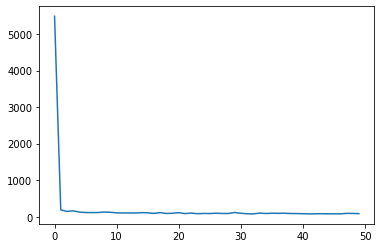

In [15]:
plt.plot(range(len(losses)), losses)

In [16]:
W2.value

array([[ 7.65285946],
       [17.85915793],
       [14.22207559],
       [ 5.66287586],
       [ 9.02925966],
       [ 6.79708692],
       [-5.3344732 ],
       [ 5.01018264],
       [ 8.12808509],
       [ 5.79824716]])

In [17]:
X_ = data['data']

In [18]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [19]:
import keras

Using TensorFlow backend.


In [20]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [21]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [22]:
model.fit(X_, y_, epochs=5000, batch_size=32)




Epoch 1/5000





506/506 [==============================] - 0s 948us/step - loss: 145.2985 - mean_squared_error: 145.2985
Epoch 2/5000
506/506 [==============================] - 0s 41us/step - loss: 82.7135 - mean_squared_error: 82.7135
Epoch 3/5000
506/506 [==============================] - 0s 41us/step - loss: 81.8098 - mean_squared_error: 81.8098
Epoch 4/5000
506/506 [==============================] - 0s 38us/step - loss: 82.8682 - mean_squared_error: 82.8682
Epoch 5/5000
506/506 [==============================] - 0s 39us/step - loss: 77.6529 - mean_squared_error: 77.6529
Epoch 6/5000
506/506 [==============================] - 0s 34us/step - loss: 83.3070 - mean_squared_error: 83.3070
Epoch 7/5000
506/506 [==============================] - 0s 38us/step - loss: 74.9545 - mean_squared_error: 74.9545
Epoch 8/5000
506/506 [==============================] - 0s 41us/step - loss: 73.5342 - mean_squared_error: 73.5342
Epoch 9/5000
506/506 [==============================] - 0s 41us/step 